## Options and Libraries

In [126]:
# this will make sure the root folder is the current working directory
from os import chdir, getcwd
from pyprojroot.here import here
chdir(here())
getcwd()

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [127]:
# main libs
import pandas as pd
import numpy as np

# graphic libs
from matplotlib import pyplot as plt
import seaborn as sns

# set theme for plots
sns.set_theme()

## Read data

In [128]:
df = pd.read_parquet("data/02_inter/df_01_first_look.parquet")
# data with minor modifications from 01_eda_first_look.ipynb

# one hot
df_full_dummies = pd.get_dummies(df, drop_first=True)

# Convert to integer days since 1970-01-01 (unix epoch)
df_full_dummies['dt_customer'] = (df_full_dummies['dt_customer'] - pd.Timestamp('1970-01-01')).dt.days

df_full_dummies = df_full_dummies.drop(columns=[
    "response",
    "income_pred",
    "year_birth",
    "income_error", 
    "income_error_relative"
])

df_unscaled = df_full_dummies[[
    'age',
    'education_years',
    'income',
    'kidhome',
    'teenhome',
    'marital_status_simple_Single',
    
    'mnt_wines',
    'mnt_fruits',
    'mnt_meat',
    'mnt_fish',
    'mnt_sweet',
    'mnt_gold',
    'mnt_total',
    
    'recency',

    
    'num_deals',
    'num_web',
    'num_catalog',
    'num_store',
    'num_web_visits_month',
    'num_total',
    
    'accepted_total',
    ]]

In [129]:
# dropping some columns for "more targeted model"
regex_drop = r"error"
drop_cols = df_unscaled.filter(regex=regex_drop).columns

print(drop_cols)
df_unscaled.drop(columns=drop_cols, inplace=True)

Index([], dtype='object')


## K-Means Clustering

In [130]:
from sklearn.preprocessing import StandardScaler
df_scaled = StandardScaler().fit_transform(df_unscaled)
df_scaled = pd.DataFrame(df_scaled, columns = df_unscaled.columns)
df_scaled.head(6)

,age,education_years,income,kidhome,teenhome,marital_status_simple_Single,mnt_wines,mnt_fruits,mnt_meat,mnt_fish,mnt_sweet,mnt_gold,mnt_total,recency,num_deals,num_web,num_catalog,num_store,num_web_visits_month,num_total,accepted_total
0,1.012620,-0.350051,0.267877,-0.825218,-0.929894,1.346874,0.983781,1.551577,1.679702,2.462147,1.476500,0.843207,1.679417,0.307039,0.366793,1.491860,2.665261,-0.550785,0.740812,1.621229,-0.439037
1,1.268542,-0.350051,-0.328028,1.032559,0.906934,1.346874,-0.870479,-0.636301,-0.713225,-0.650449,-0.631503,-0.729006,-0.961275,-0.383664,-0.168114,-1.157932,-0.591401,-1.166125,-0.123617,-1.258779,-0.439037
2,0.330160,-0.350051,0.948717,-0.825218,-0.929894,-0.742460,0.362723,0.570804,-0.177032,1.345274,-0.146905,-0.038766,0.282673,-0.798086,-0.703020,1.491860,-0.229549,1.295237,-0.555832,0.661226,-0.439037
3,-1.290681,-0.350051,-1.323292,1.032559,-0.929894,-0.742460,-0.870479,-0.560857,-0.651187,-0.503974,-0.583043,-0.748179,-0.918094,-0.798086,-0.168114,-0.779390,-0.953252,-0.550785,0.308597,-0.847349,-0.439037
4,-1.034759,1.557769,0.275709,1.032559,-0.929894,-0.742460,-0.389085,0.419916,-0.216914,0.155164,-0.001525,-0.556446,-0.305254,1.550305,1.436606,0.356235,0.132302,0.064556,-0.123617,0.524083,-0.439037
5,0.159545,0.285889,0.488929,-0.825218,0.906934,-0.742460,0.642051,0.394768,-0.305541,-0.687068,0.361924,-0.575619,0.183025,-1.143438,-0.168114,0.734776,0.494153,1.295237,0.308597,1.072656,-0.439037


In [131]:
# for both models
n_clusters = 3

In [132]:
from sklearn.cluster import KMeans

np.random.seed(42)

# Fit KMeans
kmeans_model = KMeans(n_clusters=n_clusters, random_state=42, init="k-means++", max_iter=1000)
kmeans_model.fit(df_scaled)

# Predict probabilities for each cluster
kmeans_pred_proba_array = kmeans_model.transform(df_scaled)  # Distance to centroids
kmeans_pred_proba_array = 1 / (1 + kmeans_pred_proba_array)  # Convert distances to probabilities
kmeans_pred_proba_array /= kmeans_pred_proba_array.sum(axis=1, keepdims=True)  # Normalize
df_pred_kmeans = kmeans_model.labels_

# Merge prediction back into df
column_names = [f'prob_cluster_{i}' for i in range(1, n_clusters + 1)]
df_kmeans_pred_proba = pd.DataFrame(kmeans_pred_proba_array, columns=column_names)
df_kmeans_pred_proba['pred_cluster'] = (df_pred_kmeans + 1)  # Add one to start at 1, not 0


In [133]:
def reorder_clusters(df, cluster_col='pred_cluster', order_by='income'):
    dfc = df.copy()
    # Calculate the average income for each cluster
    cluster_avg_income = dfc.groupby(cluster_col)[order_by].mean().sort_values(ascending=False)
    cluster_avg_income = pd.to_numeric(cluster_avg_income)
    
    # Create a mapping of cluster labels to new labels
    new_cluster_labels = {old_label: f'{i+1}' for i, old_label in enumerate(cluster_avg_income.index)}
    
    # Re-map the cluster column
    dfc['pred_cluster'] = pd.to_numeric(dfc[cluster_col].map(new_cluster_labels))
    
    # Rename the probability columns based on the new cluster order
    for old_label, new_label in new_cluster_labels.items():
        prob_col_name = f'prob_cluster_{old_label}'
        if prob_col_name in dfc.columns:
            
            # Rename the column
            dfc.rename(columns={prob_col_name: f'_prob_{new_label}'}, inplace=True)
            #dfc.drop(columns="pred_cluster", axis=1, inplace=True)
    
    # Reorder the columns to have a nice order
    cols = []  # Start with the reordered cluster column
    cluster_cols = [col for col in dfc.columns if '_prob_' in col]  # All probability columns
    cluster_cols = sorted(cluster_cols)
    other_cols = [col for col in dfc.columns if col not in cols + cluster_cols]  # All other columns
    dfc = dfc[cols + other_cols + cluster_cols ]

    return dfc



## PICK model df

In [134]:
# pick winner (comment out the other)
x_winner = df_kmeans_pred_proba

# Append to existing DataFrame
df_predicted = pd.concat(
    [df_unscaled.reset_index(drop=True),
    x_winner.reset_index(drop=True)], axis=1, ignore_index=False)

# reorder the cluster by: 
order_by = "income" # mnt_total is also a good one
order_by = "mnt_total" # mnt_total is also a good one
df_unscaled = reorder_clusters(df_predicted, order_by=order_by)

df_unscaled.groupby("pred_cluster").mean()

,age,education_years,income,kidhome,teenhome,marital_status_simple_Single,mnt_wines,mnt_fruits,mnt_meat,mnt_fish,mnt_sweet,mnt_gold,mnt_total,recency,num_deals,num_web,num_catalog,num_store,num_web_visits_month,num_total,accepted_total,_prob_1,_prob_2,_prob_3
pred_cluster,,,,,,,,,,,,,,,,,,,,,,,,
1,46.639507,17.100346,76078.497827,0.041522,0.169550,0.380623,613.870242,67.788927,459.401384,99.290657,70.693772,77.766436,1388.811419,49.870242,1.252595,5.119377,5.922145,8.320069,2.785467,23.577855,0.726644,0.418777,0.321381,0.259842
2,50.061776,17.857600,57492.373546,0.265600,0.920000,0.329600,454.049600,23.137600,135.456000,30.088000,22.835200,60.132800,725.699200,47.862400,3.912000,6.368000,3.036800,7.689600,5.901152,27.019200,0.252800,0.293827,0.407864,0.298309
3,43.475810,16.645130,37075.300228,0.776278,0.444552,0.356798,40.711668,5.085824,22.925747,7.581485,5.292189,15.503375,97.100289,49.436837,1.943105,2.076181,0.559306,3.235294,6.309007,14.161041,0.085824,0.226923,0.299623,0.473454


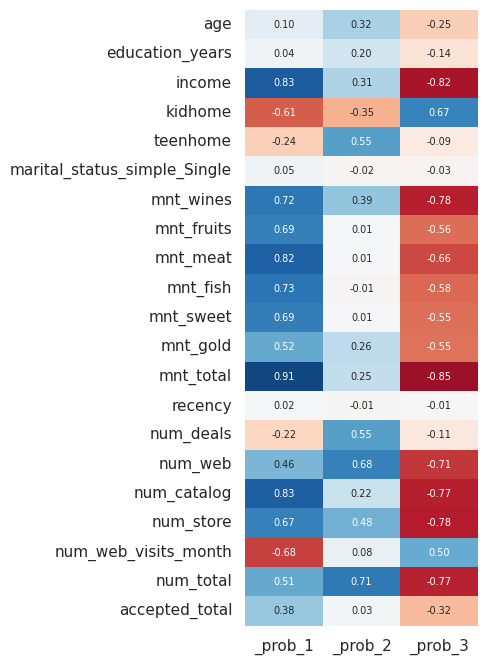

In [135]:
# get correlations 
df_unscaled = pd.get_dummies(df_unscaled, drop_first=False)
df_corr = df_unscaled.corr()
# remove from bottom
df_corr = df_corr.filter(regex="prob", axis=1)
# remove from left
df_corr.drop(["pred_cluster", "_prob_1", "_prob_2", "_prob_3"], axis=0, inplace=True)


from matplotlib import pyplot as plt
import seaborn as sns

def heatmap(df, file_name=None, figsize=(10,5)):

    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(
        df,
        cmap='RdBu',
        annot=True,
        fmt=".2f",
        annot_kws={"size": 7},
        vmin=-1, vmax=1,
        cbar=False
    )

    if file_name is not None:
        # save the plot as JPG file
        #print(f"saving {file_name}")
        plt.savefig(
            file_name,
            dpi=300,
            bbox_inches='tight'
        )
        #plt.xticks(rotation=0)
        plt.show()


heatmap(df_corr,
    file_name=f"output/figures/fig_corrplot_first_look_{n_clusters}_clst_income_pred.png",
    figsize=(3,8)
)

In [136]:
# df_predicted.value_counts("pred_custer")
df_unscaled["pred_cluster"].value_counts()

pred_cluster
3    1037
2     625
1     578
Name: count, dtype: int64

## PCA

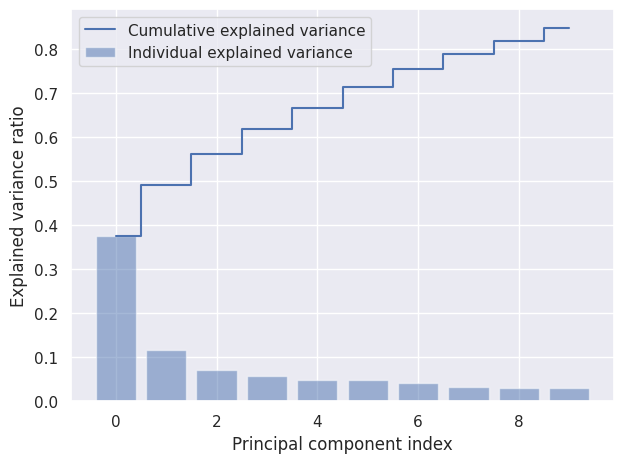

In [137]:
from sklearn.decomposition import PCA
pca = PCA(n_components=10)
pca.fit_transform(df_scaled)

exp_var_pca_sng = pca.explained_variance_ratio_
exp_var_pca_sum = np.cumsum(pca.explained_variance_ratio_)

plt.bar(range(0,len(exp_var_pca_sng)), exp_var_pca_sng, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(exp_var_pca_sum)), exp_var_pca_sum, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [138]:
_pca_1 = df_scaled.dot(pca.components_[0])
_pca_2 = df_scaled.dot(pca.components_[1])

df_unscaled["pca_1"] = _pca_1
df_unscaled["pca_2"] = _pca_2

df_full_dummies["pca_1"] = _pca_1
df_full_dummies["pca_2"] = _pca_2
df_full_dummies["pred_cluster"] = df_unscaled["pred_cluster"]

In [139]:
df_unscaled.groupby("pred_cluster").mean()

,age,education_years,income,kidhome,teenhome,marital_status_simple_Single,mnt_wines,mnt_fruits,mnt_meat,mnt_fish,mnt_sweet,mnt_gold,mnt_total,recency,num_deals,num_web,num_catalog,num_store,num_web_visits_month,num_total,accepted_total,_prob_1,_prob_2,_prob_3,pca_1,pca_2
pred_cluster,,,,,,,,,,,,,,,,,,,,,,,,,,
1,46.639507,17.100346,76078.497827,0.041522,0.169550,0.380623,613.870242,67.788927,459.401384,99.290657,70.693772,77.766436,1388.811419,49.870242,1.252595,5.119377,5.922145,8.320069,2.785467,23.577855,0.726644,0.418777,0.321381,0.259842,3.668477,-1.108043
2,50.061776,17.857600,57492.373546,0.265600,0.920000,0.329600,454.049600,23.137600,135.456000,30.088000,22.835200,60.132800,725.699200,47.862400,3.912000,6.368000,3.036800,7.689600,5.901152,27.019200,0.252800,0.293827,0.407864,0.298309,0.842719,1.815201
3,43.475810,16.645130,37075.300228,0.776278,0.444552,0.356798,40.711668,5.085824,22.925747,7.581485,5.292189,15.503375,97.100289,49.436837,1.943105,2.076181,0.559306,3.235294,6.309007,14.161041,0.085824,0.226923,0.299623,0.473454,-2.552632,-0.476424


In [140]:
# plot opts
sns.set_theme()
p_pal = sns.color_palette("viridis", as_cmap=True)
p_alpha = 1/2

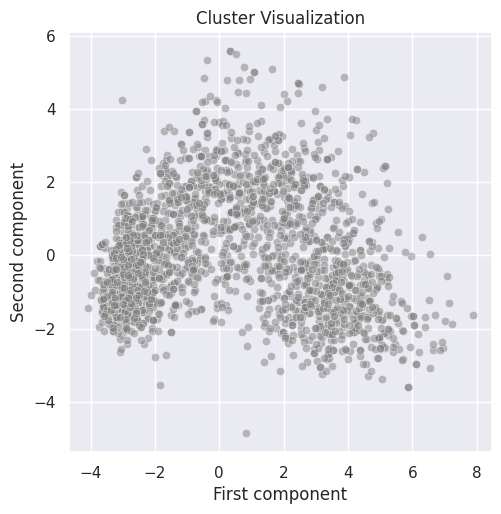

In [141]:
plt.figure(figsize = (12,12))
ax = plt.subplot(2,2,1)
sns.scatterplot(data=df_unscaled, x="pca_1", y="pca_2", c="grey", alpha=p_alpha, palette=p_pal)
plt.title("Cluster Visualization")
plt.xlabel("First component")
plt.ylabel("Second component")

plt.savefig(
    "output/figures/fig_scatter_pca1_pca2_NO_COLOR.png",
    dpi=300,
    bbox_inches='tight'
)

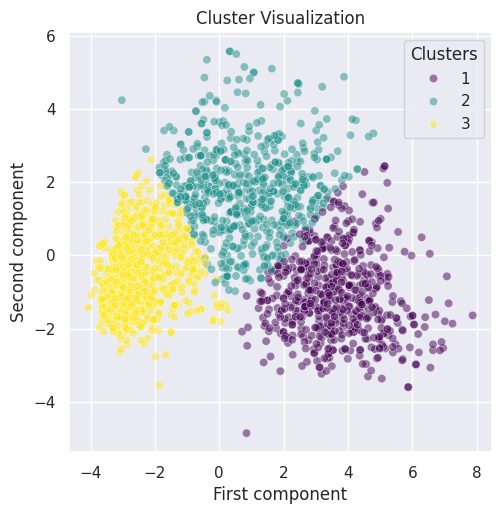

In [142]:
plt.figure(figsize = (12,12))
ax = plt.subplot(2,2,1)
sns.scatterplot(data=df_unscaled, x="pca_1", y="pca_2", hue="pred_cluster", alpha=p_alpha, palette=p_pal)
plt.title("Cluster Visualization")
plt.xlabel("First component")
plt.ylabel("Second component")
plt.legend(title='Clusters')

plt.savefig(
    "output/figures/fig_scatter_pca1_pca2.png",
    dpi=300,
    bbox_inches='tight'
)

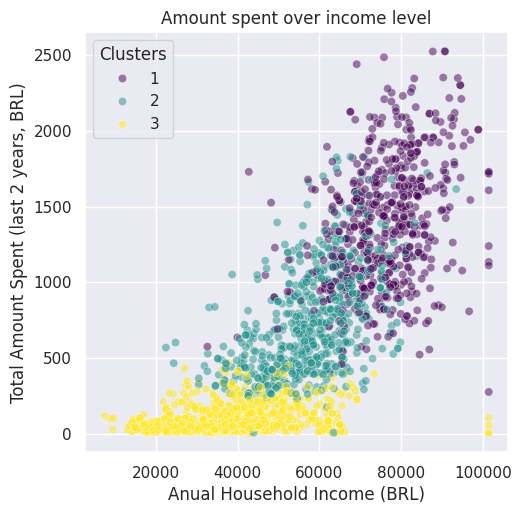

In [143]:
plt.figure(figsize = (12,12))
ax = plt.subplot(2,2,1)
sns.scatterplot(data=df_unscaled, x="income", y="mnt_total", hue="pred_cluster", alpha=p_alpha, palette=p_pal)
plt.title("Amount spent over income level")
plt.xlabel("Anual Household Income (BRL)")
plt.ylabel("Total Amount Spent (last 2 years, BRL)")
plt.legend(title='Clusters')
plt.savefig(
    "output/figures/fig_scatter_income_mnt_total.png",
    dpi=300,
    bbox_inches='tight'
)

<Axes: xlabel='income', ylabel='mnt_wines'>

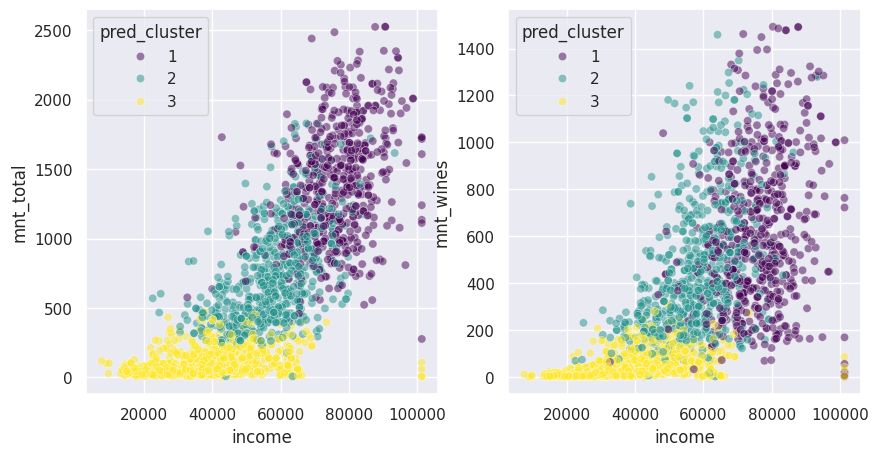

In [144]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
ax = plt.subplot(1,2,1)
sns.scatterplot(data=df_unscaled, x="income", y="mnt_total", hue="pred_cluster",  alpha=p_alpha, palette=p_pal)
ax = plt.subplot(1,2,2)
sns.scatterplot(data=df_unscaled, x="income", y="mnt_wines", hue="pred_cluster",  alpha=p_alpha, palette=p_pal)

## Summary Stats

In [145]:
def summary_stats_by_group(df, group_var, target_var, sorted=False):
    
    # Calculate the summary statistics
    summary = df.groupby(group_var)[target_var].agg(
        count="count",  # Count the number of occurrences
        mean="mean",
    ).reset_index()

    # Sort by mean value (descending order)
    if sorted: summary = summary.sort_values(by="mean", ascending=True)

    return summary.style.hide()

In [146]:
def group_mean(df, group_var, vars_to_avg):
    """
    Aggregates by a group variable and calculates mean for specified variables.

    Parameters:
    - df: pd.DataFrame - The input DataFrame.
    - group_var: str - The column name to group by.
    - vars_to_avg: list - List of column names to calculate the mean for.

    Returns:
    - pd.DataFrame - Aggregated DataFrame with mean values.
    """
    return df.groupby(group_var)[vars_to_avg].mean().reset_index()

In [147]:
df_unscaled["accepted_total"]

0       0
1       0
2       0
3       0
4       0
       ..
2235    0
2236    1
2237    1
2238    0
2239    0
Name: accepted_total, Length: 2240, dtype: int64

In [148]:
df_tbl = group_mean(df_full_dummies, group_var="pred_cluster", vars_to_avg=[
    "income", "age", "mnt_wines", "mnt_total", "num_web", "num_web_visits_month", "num_total", "num_catalog", "accepted_any", "accepted_total"
    ])

print(df_tbl)
df_tbl.to_csv("output/tables/mean_by_cluster.csv")

   pred_cluster        income  ...  accepted_any  accepted_total
0             1  76078.497827  ...      0.429066        0.726644
1             2  57492.373546  ...      0.206400        0.252800
2             3  37075.300228  ...      0.082932        0.085824

[3 rows x 11 columns]


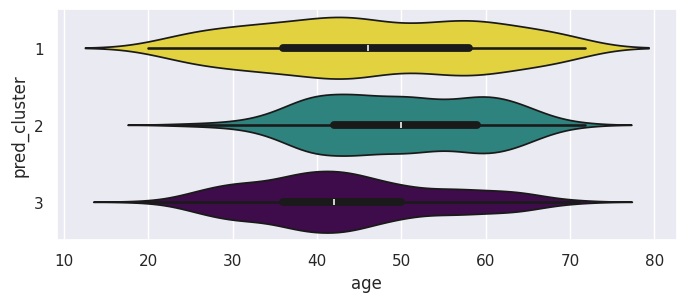

In [149]:
from matplotlib.cm import viridis
import matplotlib.cm as cm
palette = sns.color_palette("viridis", as_cmap=False, n_colors=3)  # Viridis palette
viridis = cm.get_cmap("viridis", 256)
extreme_colors = [viridis(1.0), viridis(0.5), viridis(0.0)]  # Purple, Green, Yellow
plt.figure(figsize=(8, 3))  # Width 10, height 6
sns.violinplot(
    x="age", y="pred_cluster", hue="pred_cluster",
    data=df_full_dummies,palette=extreme_colors, orient="h",
)
plt.legend().remove()

In [150]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

def horizontal_violin_plots(df, features, group_col, palette_name="viridis", figsize=(8, 3)):
    """
    Creates horizontal violin plots for a list of features.

    Parameters:
    - df (pd.DataFrame): The input DataFrame.
    - features (list): List of feature column names to plot.
    - group_col (str): Column name to group and color by.
    - palette_name (str): Name of the colormap (default: 'viridis').
    - figsize (tuple): Figure size for each plot.

    Returns:
    - None: Displays the plots.
    """
    # Prepare the colormap with extreme colors
    cmap = cm.get_cmap(palette_name, 256)
    extreme_colors = [cmap(1.0), cmap(0.5), cmap(0.0)]  # Yellow, Green, Purple

    for feature in features:
        plt.figure(figsize=figsize)
        sns.violinplot(
            x=feature, y=group_col, hue=group_col,
            data=df, palette=extreme_colors, orient="h"
        )
        plt.title(f"Violin Plot: {feature} by {group_col}")
        plt.legend().remove()  # Remove legend for cleaner plots
        plt.tight_layout()
        plt.show()

# Example usage (replace with your DataFrame and columns):
# horizontal_violin_plots(df_full_dummies, ["age", "income", "score"], group_col="pred_cluster")

In [151]:
df_full_dummies.columns

Index(['id', 'age', 'education_years', 'income', 'kidhome', 'teenhome',
       'dt_customer', 'recency', 'mnt_wines', 'mnt_fruits', 'mnt_meat',
       'mnt_fish', 'mnt_sweet', 'mnt_gold', 'mnt_total', 'num_deals',
       'num_web', 'num_catalog', 'num_store', 'num_web_visits_month',
       'num_total', 'accepted_cmp1', 'accepted_cmp2', 'accepted_cmp3',
       'accepted_cmp4', 'accepted_cmp5', 'complain', 'accepted_total',
       'accepted_any', 'education_2n Cycle', 'education_Graduation',
       'education_Master', 'education_PhD', 'marital_status_Married',
       'marital_status_Single', 'marital_status_Together',
       'marital_status_Widow', 'marital_status_simple_Single', 'pca_1',
       'pca_2', 'pred_cluster'],
      dtype='object')

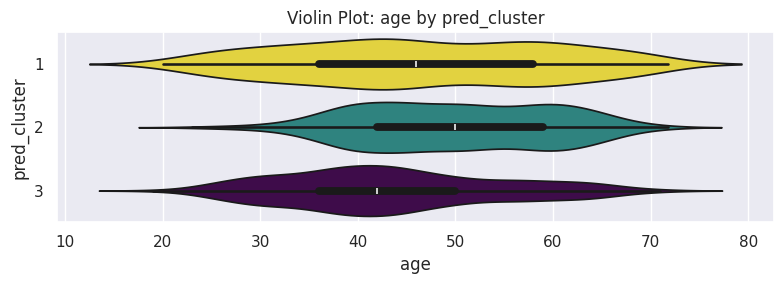

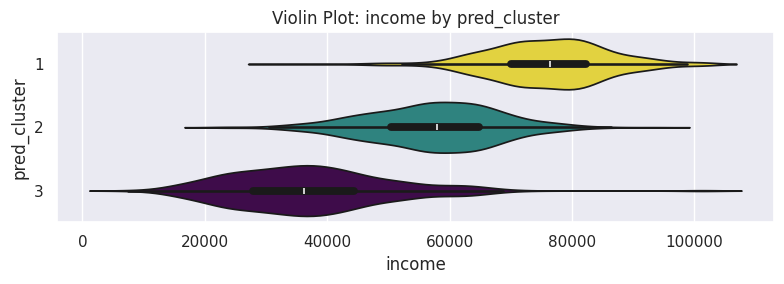

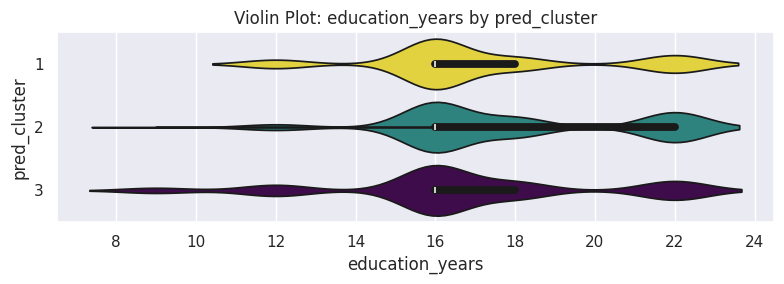

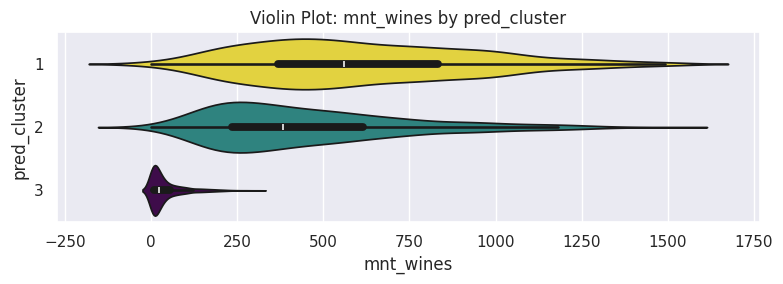

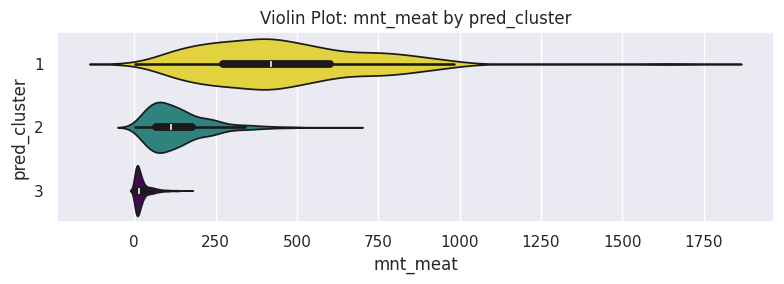

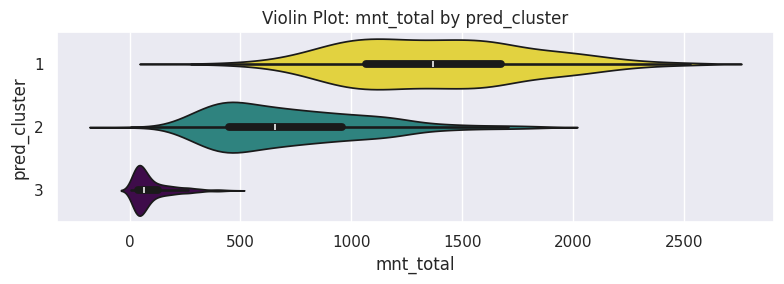

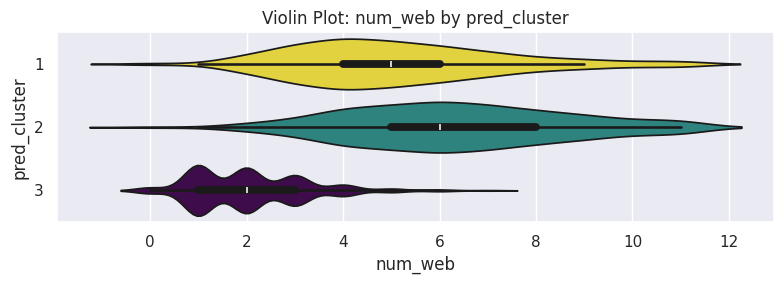

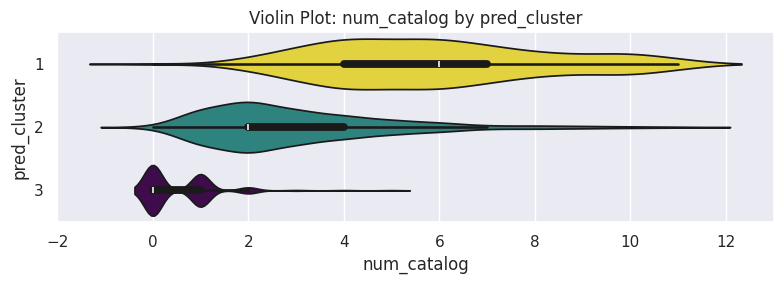

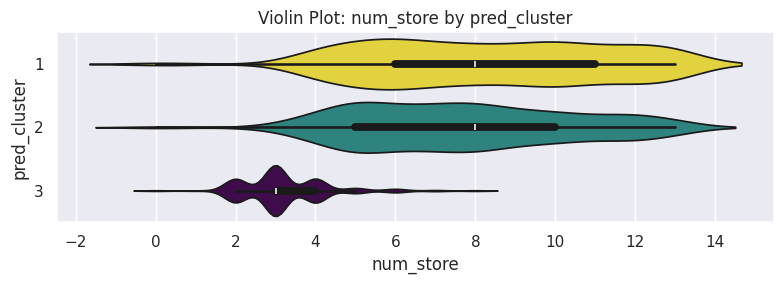

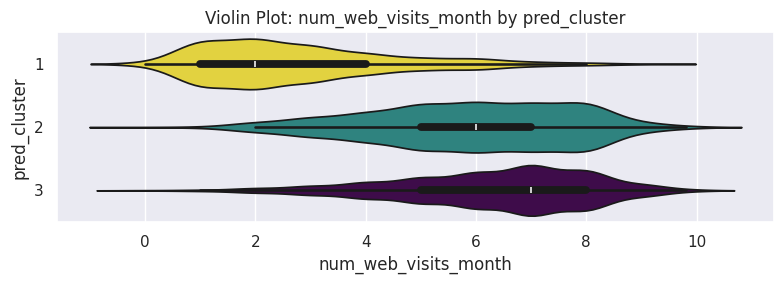

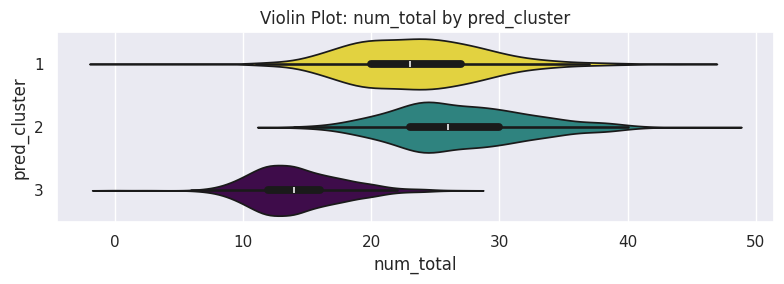

In [152]:
horizontal_violin_plots(df_full_dummies, features=["age", "income", "education_years"], group_col="pred_cluster")
horizontal_violin_plots(df_full_dummies, features=["mnt_wines", "mnt_meat", "mnt_total"], group_col="pred_cluster")
horizontal_violin_plots(df_full_dummies, features=["num_web", "num_catalog", "num_store", "num_web_visits_month", "num_total"], group_col="pred_cluster")



In [157]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import math

def horizontal_violin_plots_matrix(df, features, group_col, palette_name="viridis", ncols=2, figsize=(8, 8)):
    """
    Creates a matrix of horizontal violin plots for a list of features within one figure.

    Parameters:
    - df (pd.DataFrame): The input DataFrame.
    - features (list): List of feature column names to plot.
    - group_col (str): Column name to group and color by.
    - palette_name (str): Name of the colormap (default: 'viridis').
    - ncols (int): Number of columns in the plot grid.
    - figsize (tuple): Overall figure size.

    Returns:
    - None: Displays the matrix of plots.
    """
    # Prepare the colormap with extreme colors
    cmap = cm.get_cmap(palette_name, 256)
    extreme_colors = [cmap(1.0), cmap(0.5), cmap(0.0)]  # Yellow, Green, Purple

    nrows = math.ceil(len(features) / ncols)  # Calculate number of rows needed

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, constrained_layout=True)
    axes = axes.flatten()  # Flatten axes for easy iteration

    for i, feature in enumerate(features):
        sns.violinplot(
            x=feature, y=group_col, hue=group_col,
            data=df, palette=extreme_colors, orient="h", ax=axes[i]
        )
        axes[i].set_title(f"{feature}")
        axes[i].legend().remove()  # Remove legend for cleaner plots
        axes[i].set_xlabel("")  # Remove x-axis title
        axes[i].set_ylabel("")  # Remove y-axis title

    # Remove any unused subplots
    for j in range(len(features), len(axes)):
        fig.delaxes(axes[j])


    # plt.show()

# Example usage (replace with your DataFrame and columns):
# horizontal_violin_plots_matrix(df_full_dummies, ["age", "income", "score"], group_col="pred_cluster", ncols=2)


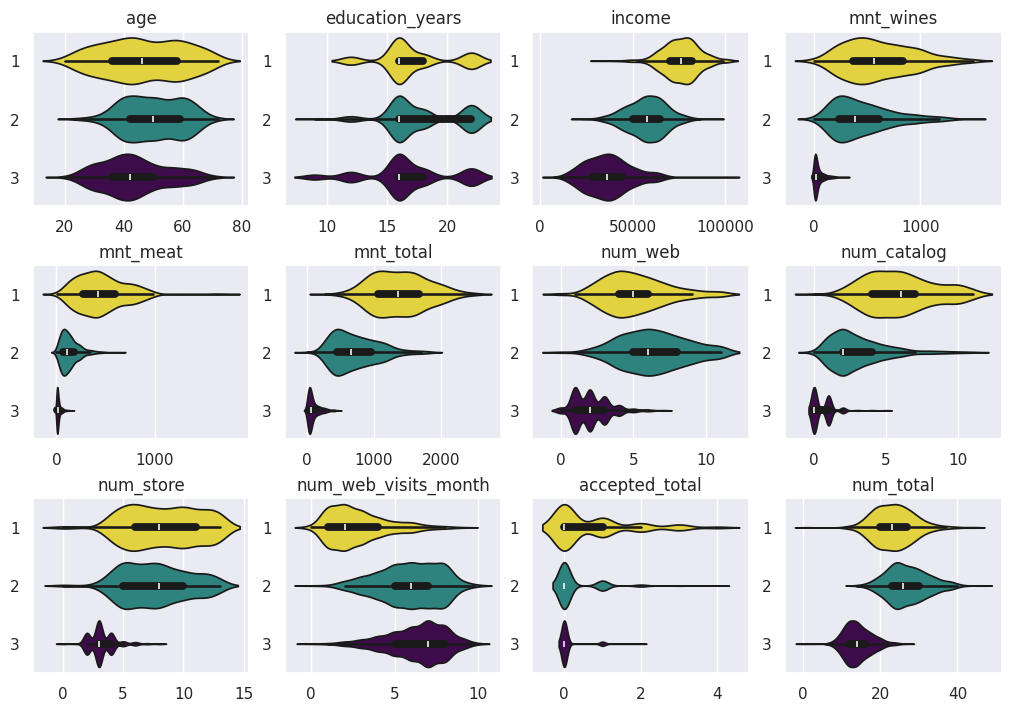

In [159]:
feat_to_plot = [
    "age", "education_years", "income", "mnt_wines", 
    "mnt_meat", "mnt_total" , "num_web", "num_catalog",
    "num_store", "num_web_visits_month", "accepted_total", "num_total" 
]
horizontal_violin_plots_matrix(df_full_dummies, features=feat_to_plot, group_col="pred_cluster", figsize=(10,7), ncols=4)
plt.savefig(
    "output/figures/fig_vioplot_overview.jpg",
    dpi=300,
    bbox_inches='tight'
)
plt.show()